## DetideNet
Lguensat et al. 2020

##### The code is shared to help reproduce the results and understand the ideas, but is still not optimal, come back soon for a better version 

In [1]:
!nvidia-smi

Mon Jun 22 01:06:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:1D:00.0 Off |                    0 |
| N/A   36C    P0    56W / 300W |      0MiB / 32510MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
%matplotlib inline

# standard imports
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy import ndimage
import cmocean
import IPython.display as dis
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xarray as xr

### loading datasets (OSMOSIS region)

In [4]:
DataOSMOSIS = xr.open_dataset('../Data/OSMOSISb_JASpv_avef_filtered_SSH_SST.nc')

Tidefield = DataOSMOSIS.ssh_inst
avgfield = DataOSMOSIS.ssh_invGeo

In [5]:
DataOSMOSIS

<xarray.Dataset>
Dimensions:       (time_counter: 2175, x: 203, y: 452)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2009-07-01T16:32:00 ... 2009-09-30T06:28:16
Dimensions without coordinates: x, y
Data variables:
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    ssh_inst      (time_counter, y, x) float32 ...
    ssh_invGeo    (time_counter, y, x) float32 ...
    sst_inst      (time_counter, y, x) float32 ...

### show an example of a field with tide, our ground truth filtered field and the difference
It's more visible using laplacians

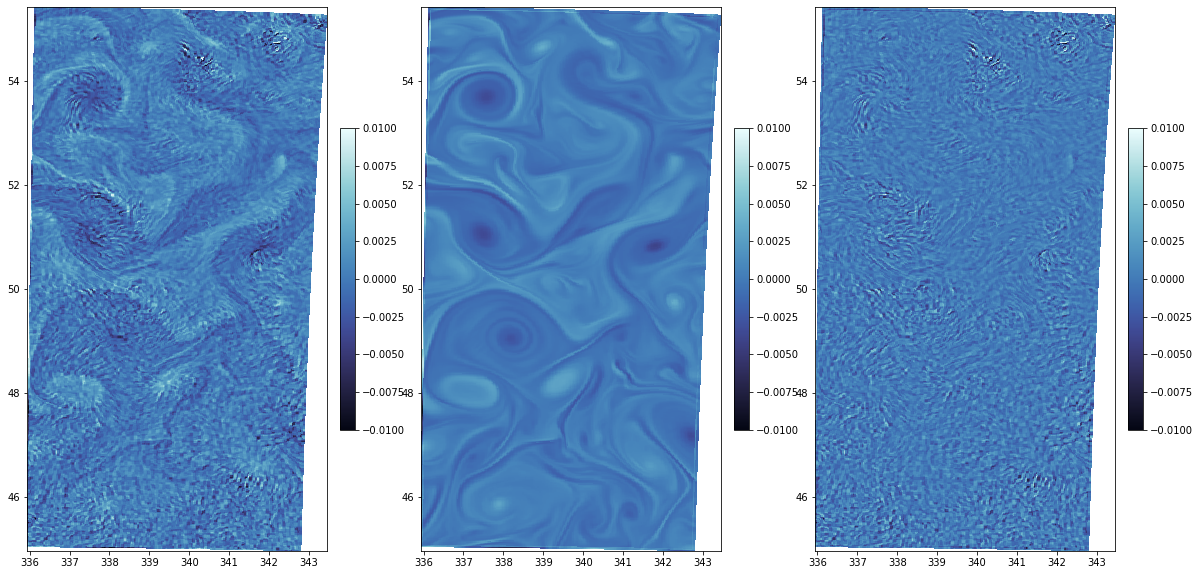

In [6]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.pcolormesh(DataACORES.nav_lon, DataACORES.nav_lat, ndimage.laplace(Tidefield[1000,:,:], mode='nearest'), cmap=cmocean.cm.ice)
plt.clim(-0.01,0.01)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,3,2)
plt.pcolormesh(DataACORES.nav_lon, DataACORES.nav_lat, ndimage.laplace(avgfield[1000,:,:], mode='nearest'), cmap=cmocean.cm.ice)
plt.clim(-0.01,0.01)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,3,3)
plt.pcolormesh(DataACORES.nav_lon, DataACORES.nav_lat, ndimage.laplace(Tidefield[1000,:,:] - avgfield[1000,:,:], mode='nearest'), cmap=cmocean.cm.ice)
plt.clim(-0.01,0.01)
plt.colorbar(fraction=0.046, pad=0.04)

### Train data
* We split the region into 8 boxes of 96x96 pixels
* We create triplets of SSH(hour),SSH(hour-24h),SSH(hour+24h)
* current code is not optimal (working on it)

In [7]:
Dayminus1 = np.concatenate((np.expand_dims(Tidefield[:-48,5:101,5:101][:-480,:,:],1),
                                 np.expand_dims(Tidefield[:-48,101:197,5:101][:-480,:,:],1),
                                 np.expand_dims(Tidefield[:-48,197:293,5:101][:-480,:,:],1),
                                 np.expand_dims(Tidefield[:-48,5:101,101:197][:-480,:,:],1),
                                 np.expand_dims(Tidefield[:-48,101:197,101:197][:-480,:,:],1),
                                 np.expand_dims(Tidefield[:-48,197:293,101:197][:-480,:,:],1),
                                 np.expand_dims(Tidefield[:-48,293:389,5:101][:-480,:,:],1),
                                 np.expand_dims(Tidefield[:-48,293:389,101:197][:-480,:,:],1)),0)

Dayplus1 = np.concatenate((np.expand_dims(Tidefield[48:,5:101,5:101][:-480,:,:],1),
                                 np.expand_dims(Tidefield[48:,101:197,5:101][:-480,:,:],1),
                                 np.expand_dims(Tidefield[48:,197:293,5:101][:-480,:,:],1),
                                 np.expand_dims(Tidefield[48:,5:101,101:197][:-480,:,:],1),
                                 np.expand_dims(Tidefield[48:,101:197,101:197][:-480,:,:],1),
                                 np.expand_dims(Tidefield[48:,197:293,101:197][:-480,:,:],1),
                                 np.expand_dims(Tidefield[48:,293:389,5:101][:-480,:,:],1),
                                 np.expand_dims(Tidefield[48:,293:389,101:197][:-480,:,:],1)),0)

Daydata = np.concatenate((np.expand_dims(Tidefield[24:-24,5:101,5:101][:-480,:,:],1),
                                 np.expand_dims(Tidefield[24:-24,101:197,5:101][:-480,:,:],1),
                                 np.expand_dims(Tidefield[24:-24,197:293,5:101][:-480,:,:],1),
                                 np.expand_dims(Tidefield[24:-24,5:101,101:197][:-480,:,:],1),
                                 np.expand_dims(Tidefield[24:-24,101:197,101:197][:-480,:,:],1),
                                 np.expand_dims(Tidefield[24:-24,197:293,101:197][:-480,:,:],1),
                                 np.expand_dims(Tidefield[24:-24,293:389,5:101][:-480,:,:],1),
                                 np.expand_dims(Tidefield[24:-24,293:389,101:197][:-480,:,:],1)),0)


Dayminus1.shape, Daydata.shape, Dayplus1.shape

((13176, 1, 96, 96), (13176, 1, 96, 96), (13176, 1, 96, 96))

In [8]:
Original_train = np.concatenate((Dayminus1,Daydata,Dayplus1),1)

Original_train.shape

(13176, 3, 96, 96)

In [9]:
#######
Detide_train =  np.concatenate((np.expand_dims(avgfield[24:-24,5:101,5:101][:-480,:,:],1),
                                 np.expand_dims(avgfield[24:-24,101:197,5:101][:-480,:,:],1),
                                 np.expand_dims(avgfield[24:-24,197:293,5:101][:-480,:,:],1),
                                 np.expand_dims(avgfield[24:-24,5:101,101:197][:-480,:,:],1),
                                 np.expand_dims(avgfield[24:-24,101:197,101:197][:-480,:,:],1),
                                 np.expand_dims(avgfield[24:-24,197:293,101:197][:-480,:,:],1),
                                 np.expand_dims(avgfield[24:-24,293:389,5:101][:-480,:,:],1),
                                 np.expand_dims(avgfield[24:-24,293:389,101:197][:-480,:,:],1)),0)
Detide_train.shape

(13176, 1, 96, 96)

#### Val data

In [10]:
Dayminus1_val = np.concatenate((np.expand_dims(Tidefield[:-48,5:101,5:101][-240:,:,:],1),
                                 np.expand_dims(Tidefield[:-48,101:197,5:101][-240:,:,:],1),
                                 np.expand_dims(Tidefield[:-48,197:293,5:101][-240:,:,:],1),
                                 np.expand_dims(Tidefield[:-48,5:101,101:197][-240:,:,:],1),
                                 np.expand_dims(Tidefield[:-48,101:197,101:197][-240:,:,:],1),
                                 np.expand_dims(Tidefield[:-48,197:293,101:197][-240:,:,:],1),
                                 np.expand_dims(Tidefield[:-48,293:389,5:101][:-240,:,:],1),
                                 np.expand_dims(Tidefield[:-48,293:389,101:197][:-240,:,:],1)),0)

Dayplus1_val = np.concatenate((np.expand_dims(Tidefield[48:,5:101,5:101][-240:,:,:],1),
                                 np.expand_dims(Tidefield[48:,101:197,5:101][-240:,:,:],1),
                                 np.expand_dims(Tidefield[48:,197:293,5:101][-240:,:,:],1),
                                 np.expand_dims(Tidefield[48:,5:101,101:197][-240:,:,:],1),
                                 np.expand_dims(Tidefield[48:,101:197,101:197][-240:,:,:],1),
                                 np.expand_dims(Tidefield[48:,197:293,101:197][-240:,:,:],1),
                                 np.expand_dims(Tidefield[48:,293:389,5:101][:-240,:,:],1),
                                 np.expand_dims(Tidefield[48:,293:389,101:197][:-240,:,:],1)),0)

Daydata_val = np.concatenate((np.expand_dims(Tidefield[24:-24,5:101,5:101][-240:,:,:],1),
                                 np.expand_dims(Tidefield[24:-24,101:197,5:101][-240:,:,:],1),
                                 np.expand_dims(Tidefield[24:-24,197:293,5:101][-240:,:,:],1),
                                 np.expand_dims(Tidefield[24:-24,5:101,101:197][-240:,:,:],1),
                                 np.expand_dims(Tidefield[24:-24,101:197,101:197][-240:,:,:],1),
                                 np.expand_dims(Tidefield[24:-24,197:293,101:197][-240:,:,:],1),
                                 np.expand_dims(Tidefield[24:-24,293:389,5:101][:-240,:,:],1),
                                 np.expand_dims(Tidefield[24:-24,293:389,101:197][:-240,:,:],1)),0)

Dayminus1_val.shape, Daydata_val.shape, Dayplus1_val.shape

((5214, 1, 96, 96), (5214, 1, 96, 96), (5214, 1, 96, 96))

In [11]:
Original_val = np.concatenate((Dayminus1_val,Daydata_val,Dayplus1_val),1)
#######
Detide_val =  np.concatenate((np.expand_dims(avgfield[24:-24,5:101,5:101][-240:,:,:],1),
                                 np.expand_dims(avgfield[24:-24,101:197,5:101][-240:,:,:],1),
                                 np.expand_dims(avgfield[24:-24,197:293,5:101][-240:,:,:],1),
                                 np.expand_dims(avgfield[24:-24,5:101,101:197][-240:,:,:],1),
                                 np.expand_dims(avgfield[24:-24,101:197,101:197][-240:,:,:],1),
                                 np.expand_dims(avgfield[24:-24,197:293,101:197][-240:,:,:],1),
                                 np.expand_dims(avgfield[24:-24,293:389,5:101][:-240,:,:],1),
                                 np.expand_dims(avgfield[24:-24,293:389,101:197][:-240,:,:],1)),0)
#####
Original_val.shape, Detide_val.shape

((5214, 3, 96, 96), (5214, 1, 96, 96))

In [12]:
del Dayminus1_val,Daydata_val,Dayplus1_val,Dayminus1,Daydata,Dayplus1

centering the fields

In [13]:
Original_train_scaled = (Original_train - np.mean(Original_train, axis=(0,2,3),keepdims=True))/np.std(Original_train, axis=(0,2,3),keepdims=True)
Original_val_scaled = (Original_val - np.mean(Original_train, axis=(0,2,3),keepdims=True))/np.std(Original_train, axis=(0,2,3),keepdims=True)
Detide_train = Detide_train - np.mean(Detide_train, axis=(2,3),keepdims=True)
Detide_val = Detide_val - np.mean(Detide_val, axis=(2,3),keepdims=True)

# Import libs

In [14]:
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.optim.lr_scheduler import StepLR

In [15]:
torch.backends.cudnn.deterministic = True

In [16]:
torch.__version__

'1.3.1'

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)
print(device)

cuda:0


# Build models

In [18]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.rep = nn.ReplicationPad2d(1)
        self.conv1 = nn.Conv2d(in_channels, 2*int(out_channels), 3, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.LeakyReLU(0.2,inplace=True) 
        self.conv2 = nn.Conv2d(2*int(out_channels), int(out_channels), 3, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(2*int(out_channels))
        ######
        nn.init.kaiming_normal_(self.conv1.weight.data)
        nn.init.kaiming_normal_(self.conv2.weight.data)
        nn.init.ones_(self.bn1.weight.data)
        nn.init.zeros_(self.bn2.weight.data) ### Trick
        nn.init.zeros_(self.bn1.bias.data)
        nn.init.zeros_(self.bn2.bias.data) 
    
        
    def forward(self, x):
        residual = x        
        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(self.rep(out))
        
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(self.rep(out))
        out = out + residual
        return out

In [19]:
nbf = 64

class IGWResNet(nn.Module):
    def __init__(self):
        super(IGWResNet, self).__init__() 
        self.rep = nn.ReplicationPad2d(1)
        self.FirstLayer = nn.Conv2d(3, nbf, 3, padding=0, bias = True)
        self.list_1 = nn.ModuleList([])
        for i in range(5):
            self.list_1.append(ResidualBlock(nbf,nbf))
            
        nn.init.kaiming_normal_(self.FirstLayer.weight.data)    
        self.LastLayer = nn.Conv2d(nbf, 1, 1, padding=0, bias = False)
        nn.init.zeros_(self.FirstLayer.bias.data)
        
    def forward(self, x):
        out = self.FirstLayer(self.rep(x))
        for i in range(5):
            out = self.list_1[i](out)
        out = self.LastLayer(out)
        return out - torch.mean(out, dim=(1,2,3), keepdim=True)

# Training (Adam)

## Data preparation

In [20]:
loss_fn = torch.nn.MSELoss()#.cuda()
loss_l1 = torch.nn.L1Loss()

In [21]:
gpu_ids=[0]#[0,1,2,3]
netw = IGWResNet()
netw = torch.nn.DataParallel(netw, device_ids=gpu_ids).to(device)

In [24]:
torch_dataset = Data.TensorDataset(torch.from_numpy(Original_train_scaled[:,:,:,:]).to(torch.float32),
                                   torch.from_numpy(Detide_train[:,:,:,:]).to(torch.float32))

torch_dataset_val = Data.TensorDataset(torch.from_numpy(Original_val_scaled[:,:,:,:]).to(torch.float32),
                                   torch.from_numpy(Detide_val[:,:,:,:]).to(torch.float32))

loader = Data.DataLoader(
    dataset=torch_dataset,      # torch TensorDataset format
    batch_size=32,#32*4,      # mini batch size (use 32*4 if 4 GPUs)
    shuffle=True,
    pin_memory=True
)

valloader = Data.DataLoader(
    dataset=torch_dataset_val,      # torch TensorDataset format
    batch_size=32,#32*4,      # mini batch size
    shuffle=False,               # random shuffle for training
    pin_memory=True
)

In [25]:
pytorch_total_params = sum(p.numel() for p in netw.parameters() if p.requires_grad)
pytorch_total_params

741056

In [26]:
len(loader)

206

## Training

In [28]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(netw.parameters(), lr=learning_rate)#, weight_decay=1e-7
train_loss=[]
val_loss=[]
scheduler = StepLR(optimizer, step_size=100, gamma=0.5)

In [29]:
def sshtoqSS(ssh_tensor):
    #print(ssh_tensor.shape)
    laplacian_x = torch.cuda.FloatTensor([1, -2, 1]).view([1, 1, 1, 3])
    laplacian_y = torch.transpose(laplacian_x,2,3)
    laplaciansshx = F.conv2d(ssh_tensor, laplacian_x, padding=0)
    laplaciansshy = F.conv2d(ssh_tensor, laplacian_y, padding=0)
    zp1 = nn.ZeroPad2d((1,1,0,0))
    zp2 = nn.ZeroPad2d((0,0,1,1))
    return zp1(laplaciansshx) + zp2(laplaciansshy)

def lossNN(ytrue, ypred, weight):
    mseSSH = loss_fn(ytrue,ypred)
    maePV = loss_l1(sshtoqSS(ytrue),sshtoqSS(ypred))
    return mseSSH+weight*maePV

In [ ]:
for epoch in range(2001):
    cum_loss=0.
    cum_val_loss = 0.
    # Print Learning Rate
    print('Epoch:', epoch,'LR:', scheduler.get_lr())
    #print('Epoch:', epoch)
    for phase in ['train', 'val']:
        if phase == 'train':
            netw.train()  # Set model to training mode
        else:
            netw.eval()   # Set model to evaluate mode
        
        if phase == 'train':
            for batch_idx,(sshin,ssh10in) in enumerate(loader):  ########,q10in                
                ###
                sshin_var = sshin.cuda()
                ssh10in_var = ssh10in.cuda()
                ###
                optimizer.zero_grad()
                y_pred = netw(sshin_var)
                loss = lossNN(ssh10in_var, y_pred, 1e3)                
                loss.backward()
                optimizer.step()
                cum_loss += loss.item()* sshin.shape[0]

        if phase == 'val':        
            with torch.no_grad():
                for sshinval, ssh10inval in valloader:
                    y_pred_val = netw(sshinval.to(device))
                    batch_loss = lossNN(ssh10inval.to(device), y_pred_val, 1e3)
                    cum_val_loss += batch_loss.item()* sshinval.shape[0]
    # Decay Learning Rate
    scheduler.step()
            
    print('validation loss:'+str(cum_val_loss/len(valloader)))
    val_loss.append(cum_val_loss/len(valloader))        
    print('train loss:'+str(cum_loss/len(loader)))     
    train_loss.append(cum_loss/len(loader)) 
    np.save('../trainloss_detide_paper_summerSSH3days_scaled.npy',train_loss)
    np.save('../valloss_detide_paper_summerSSH3days_scaled.npy',val_loss)
    if epoch%20==0:
        torch.save(netw.state_dict(), '../Weights/Detide_'+str(epoch)+'_detide_paper_summerSSH3days_final_scaled.pt')

Epoch: 0 LR: [0.001]
validation loss:18.854120350465543
train loss:41.84069868777562
Epoch: 1 LR: [0.001]
validation loss:17.550848558908555
train loss:18.62014448295519
Epoch: 2 LR: [0.001]
validation loss:18.37278746722675
train loss:17.72563524037889
Epoch: 3 LR: [0.001]
validation loss:17.066166526660687
train loss:17.22446083906785
Epoch: 4 LR: [0.001]
validation loss:16.627422737275683
train loss:16.927726231732414
Epoch: 5 LR: [0.001]
validation loss:16.605118617415428
train loss:16.713439205317822
Epoch: 6 LR: [0.001]
validation loss:16.405395222509778
train loss:16.523697039456042
Epoch: 7 LR: [0.001]
validation loss:16.14204591112893
train loss:16.30291612518644
Epoch: 8 LR: [0.001]
validation loss:15.829745989020278
train loss:16.07649075406269
Epoch: 9 LR: [0.001]
validation loss:15.729525203385004
train loss:15.894966134747255
Epoch: 10 LR: [0.001]
validation loss:15.913938436929772
train loss:15.794186669067273
Epoch: 11 LR: [0.001]
validation loss:15.679371904672646
trai

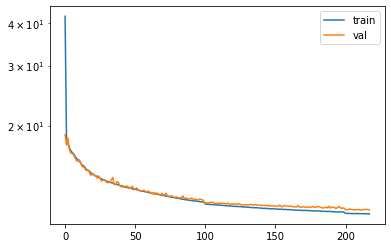

In [4]:
plt.semilogy(np.asarray(np.load('../trainloss_detide_paper_summerSSH3days_scaled.npy')), label='train')
plt.semilogy(np.asarray(np.load('../valloss_detide_paper_summerSSH3days_scaled.npy')), label='val')
plt.legend()

## Test the network 

In [39]:
randindextest = 30
randindextest

30

In [40]:
netw.eval()
res_test = netw(torch.from_numpy(Original_val[None,randindextest,:,:,:]).to(torch.float32).to(device))


Text(0.5, 1.0, 'Lap(SSH average)')

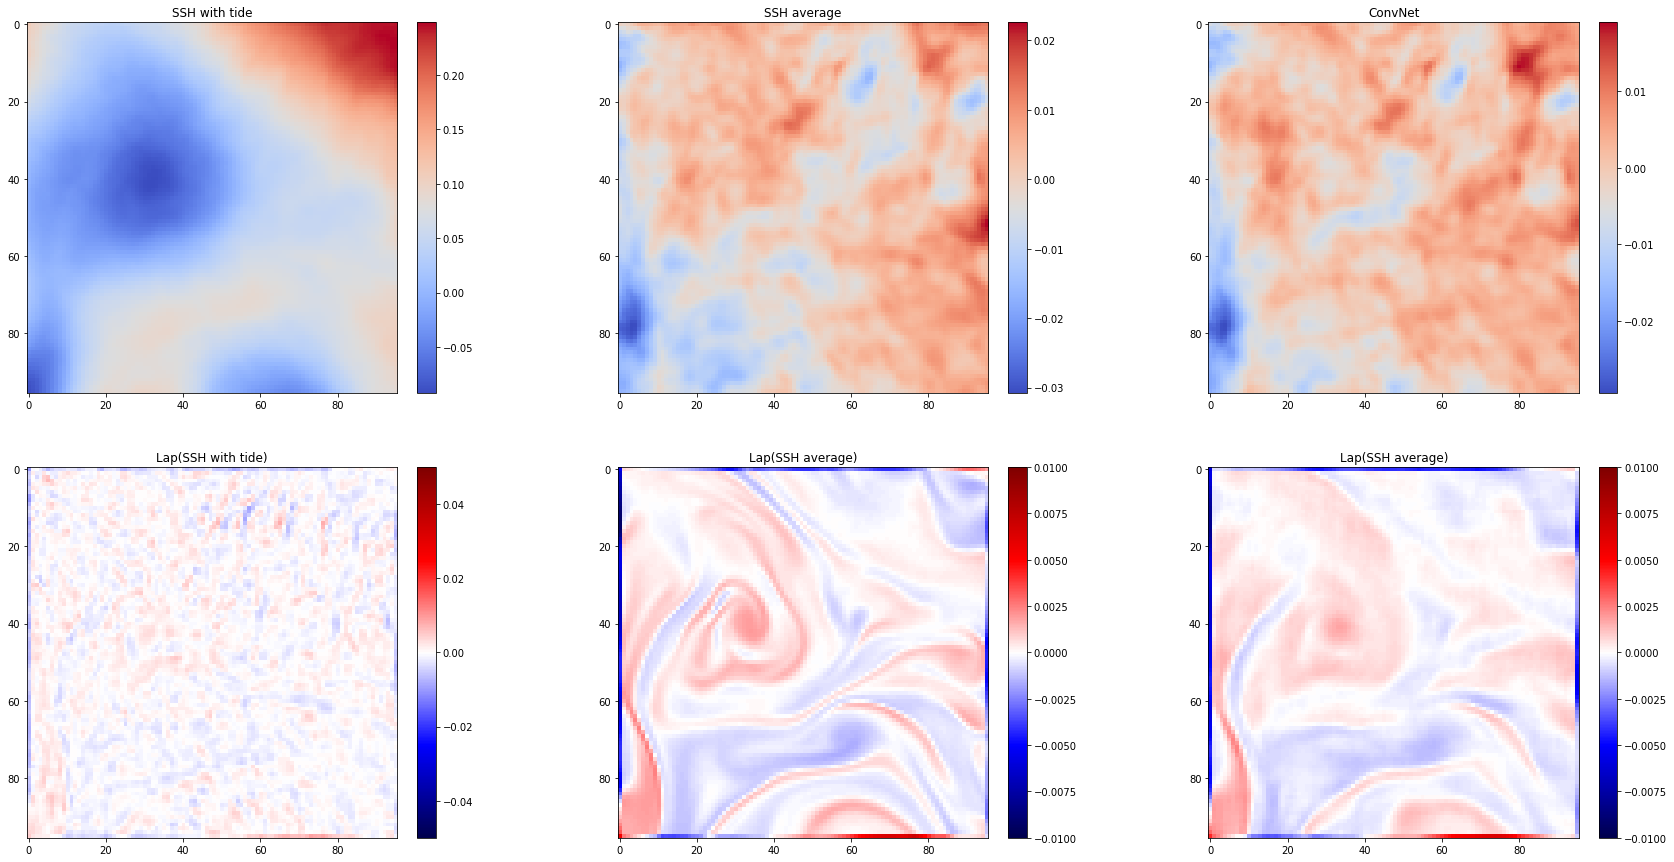

In [41]:
plt.figure(figsize=(30,15))

plt.subplot(2,3,1)
plt.imshow(Original_val[randindextest,0,:,:], cmap='coolwarm')
plt.colorbar(fraction=0.046, pad=0.04)
#plt.clim(-1,1)
plt.title('SSH with tide')

plt.subplot(2,3,2)
plt.imshow(Original_val[randindextest,0,:,:] - Detide_val[randindextest,0,:,:]
           -np.mean(Original_val[randindextest,0,:,:] - Detide_val[randindextest,0,:,:]), cmap='coolwarm')
plt.colorbar(fraction=0.046, pad=0.04)
#plt.clim(-1,1)
plt.title('SSH average')

plt.subplot(2,3,3)
plt.imshow(-(res_test[0,0,:,:].detach().cpu().numpy()-Original_val[randindextest,0,:,:]
           -np.mean(res_test[0,0,:,:].detach().cpu().numpy()-Original_val[randindextest,0,:,:])), cmap='coolwarm')
plt.colorbar(fraction=0.046, pad=0.04)
#plt.clim(-1,1)
plt.title('ConvNet')

plt.subplot(2,3,4)
plt.imshow(ndimage.laplace(Original_val[randindextest,0,:,:], mode='nearest'), cmap='seismic')
plt.colorbar(fraction=0.046, pad=0.04)
plt.clim(-0.05,0.05)
plt.title('Lap(SSH with tide)')

plt.subplot(2,3,5)
plt.imshow(ndimage.laplace(Detide_val[randindextest,0,:,:], mode='nearest'), cmap='seismic')
plt.colorbar(fraction=0.046, pad=0.04)
plt.clim(-0.01,0.01)
plt.title('Lap(SSH average)')

plt.subplot(2,3,6)
plt.imshow(ndimage.laplace(res_test[0,0,:,:].detach().cpu().numpy(), mode='nearest'), cmap='seismic')
plt.colorbar(fraction=0.046, pad=0.04)
plt.clim(-0.01,0.01)
plt.title('Lap(SSH average)')